In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Dataset Preprocessing

### Downloading the datasets.
Download the following files and place them in ./data/d1, ./data/d2, ./data/d3 respectively
1. https://www.kaggle.com/datasets/techsash/waste-classification-data
2. https://www.kaggle.com/datasets/rayhanzamzamy/non-and-biodegradable-waste-dataset
3. https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification

### Load the datasets.

In [1]:
data_path = os.path.join(os.getcwd(),"data")

def sub_load_df(path:str, is_organic: bool) -> pd.DataFrame:
    file_paths = [rf"{path}/{file_name}" for file_name in os.listdir(path)]
    image_type = [is_organic for _ in range(len(file_paths))]
    return pd.DataFrame({
        "file_path": file_paths,
        "is_organic": image_type
    })

def load_df1() -> pd.DataFrame:
    df_train_1 = sub_load_df(rf"{data_path}/d1/DATASET/TRAIN/O", True)
    df_train_2 = sub_load_df(rf"{data_path}/d1/DATASET/TRAIN/R", False)
    df_train = pd.concat([df_train_1, df_train_2], ignore_index=True)

    df_test_1 = sub_load_df(rf"{data_path}/d1/DATASET/TEST/O", True)
    df_test_2 = sub_load_df(rf"{data_path}/d1/DATASET/TEST/R", False)
    df_test = pd.concat([df_test_1, df_test_2], ignore_index=True)

    return pd.concat([df_train, df_test], ignore_index=True)

df1 = load_df1()
print(df1.head())
print(df1["is_organic"].value_counts())

                                           file_path  is_organic
0  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
1  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
2  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
3  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
4  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
is_organic
True     13966
False    11111
Name: count, dtype: int64


In [2]:
def load_df2() -> pd.DataFrame:
    train_path = rf"{data_path}/d2/TRAIN."
    df_trains = []
    for i in range(1,5):
        df_trains.append(sub_load_df(rf"{train_path}{i}/B",True))
        df_trains.append(sub_load_df(rf"{train_path}{i}/N",False))

    df_test_1 = sub_load_df(rf"{data_path}/d2/TEST/B",True)
    df_test_2 = sub_load_df(rf"{data_path}/d2/TEST/N",False)
    df_final = pd.concat([df_test_1, df_test_2], ignore_index=True)

    for df_train in df_trains:
        df_final=pd.concat([df_final,df_train], ignore_index=True)

    return df_final

df2 = load_df2()
print(df2.head())
print(df2["is_organic"].value_counts())

                                           file_path  is_organic
0  /home/espacio/ml/sem5-proj/data/d2/TEST/B/TEST...        True
1  /home/espacio/ml/sem5-proj/data/d2/TEST/B/TEST...        True
2  /home/espacio/ml/sem5-proj/data/d2/TEST/B/TEST...        True
3  /home/espacio/ml/sem5-proj/data/d2/TEST/B/TEST...        True
4  /home/espacio/ml/sem5-proj/data/d2/TEST/B/TEST...        True
is_organic
True     128208
False    128208
Name: count, dtype: int64


In [3]:
base_dir = rf"{data_path}/d3/images/images"
organic_dirs = ["food_waste", "eggshells", "coffee_grounds", "tea_bags"]
non_organic_dirs = [dir for dir in os.listdir(base_dir) if dir not in organic_dirs]

def load_df3() -> pd.DataFrame:
    df = None
    for dir in organic_dirs:
        for s_dir in ["default", "real_world"]:
            if df is None:
                df=sub_load_df(rf"{base_dir}/{dir}/{s_dir}",True)
            else:
                df=pd.concat([df,sub_load_df(rf"{base_dir}/{dir}/{s_dir}",True)], ignore_index=True)
    for dir in non_organic_dirs:
        for s_dir in ["default", "real_world"]:
            if df is not None:
                df=pd.concat([df,sub_load_df(rf"{base_dir}/{dir}/{s_dir}",False)], ignore_index=True)

    if df is None:
        return pd.DataFrame()
    else:
        return df

df3 = load_df3()
print(df3.head())
print(df3["is_organic"].value_counts())

                                           file_path  is_organic
0  /home/espacio/ml/sem5-proj/data/d3/images/imag...        True
1  /home/espacio/ml/sem5-proj/data/d3/images/imag...        True
2  /home/espacio/ml/sem5-proj/data/d3/images/imag...        True
3  /home/espacio/ml/sem5-proj/data/d3/images/imag...        True
4  /home/espacio/ml/sem5-proj/data/d3/images/imag...        True
is_organic
False    13000
True      2000
Name: count, dtype: int64


### Combine the datasets

In [4]:
df = pd.concat([df1,df2,df3], ignore_index=False)
print(df.head())
print(df["is_organic"].value_counts())

                                           file_path  is_organic
0  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
1  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
2  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
3  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
4  /home/espacio/ml/sem5-proj/data/d1/DATASET/TRA...        True
is_organic
False    152319
True     144174
Name: count, dtype: int64


### Check for inconsistencies

In [5]:
def check_jpg(df: pd.DataFrame) -> pd.DataFrame:
    bad_file_paths = []
    for img in df["file_path"]:
        if not (img.endswith(".jpg") or img.endswith(".png") or img.endswith(".jpeg")) or not os.path.exists(img):
            bad_file_paths.append(img)
        else:
            (hx,wx) = Image.open(img).size
            if (hx!=wx):
                bad_file_paths.append(img)
    print(f"{len(bad_file_paths)} paths found to have bad file paths")

    df_res = df[~df["file_path"].isin(bad_file_paths)]
    if (type(df_res)!=pd.DataFrame):
        return pd.DataFrame()
    else:
        return df_res

df = check_jpg(df)

19723 paths found to have bad file paths


### Save the dataframe

In [6]:
df.to_csv(rf"{data_path}/trash.csv", index=False)
df["is_organic"].value_counts()

is_organic
False    144607
True     132163
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

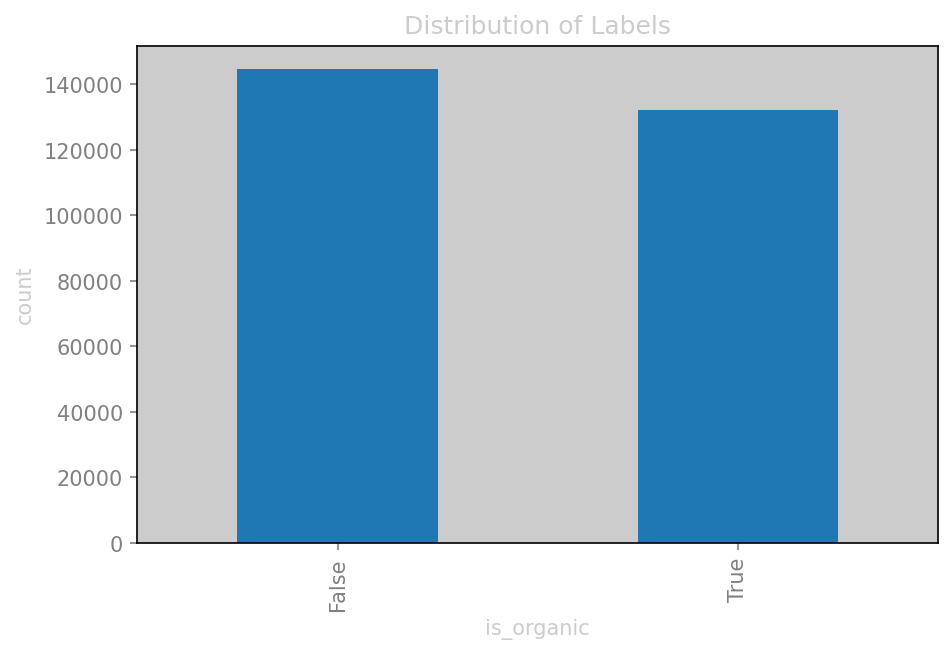

In [7]:
import matplotlib.pyplot as plt

counts = df["is_organic"].value_counts()

counts.plot(kind="bar", figsize=(8,5))
plt.xlabel("is_organic")
plt.ylabel("count")
plt.title("Distribution of Labels")
plt.show()

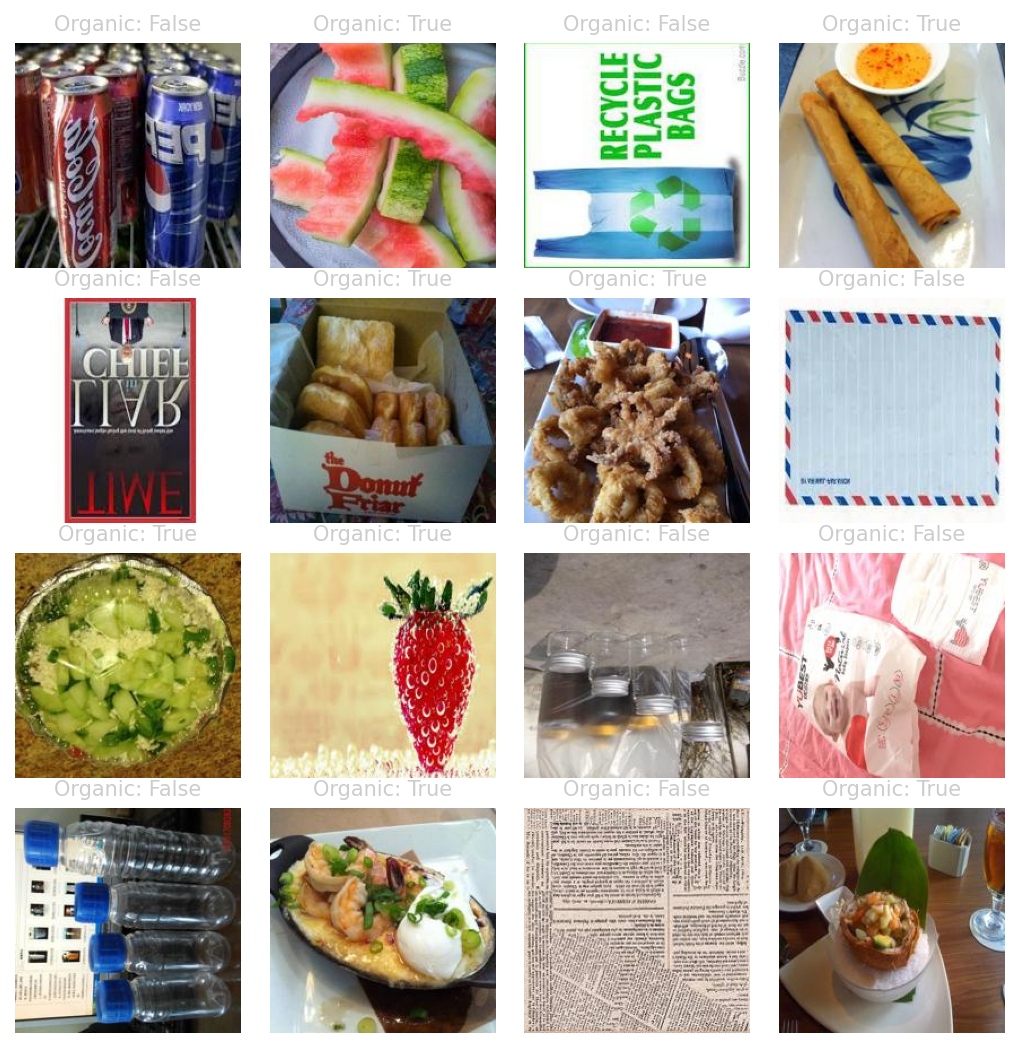

In [8]:
sample_df = df.sample(n=16)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):
    img = Image.open(row["file_path"]) # type: ignore
    ax.imshow(img)
    ax.set_title(f"Organic: {row['is_organic']}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Sample Train (AI Generated)

In [9]:
# ==========================
# 1. Set seeds for reproducibility
# ==========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ==========================
# 2. Dataset class with lazy loading
# ==========================
size = (128, 128)

class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.loc[idx, "file_path"]
        label = int(self.df.loc[idx, "is_organic"])

        img = Image.open(file_path).convert("RGB").resize(size)
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)  # scale 0-1
        return img, label

# ==========================
# 3. Simple CNN model
# ==========================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ==========================
# 4. Prepare DataLoaders
# ==========================
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["is_organic"], random_state=42)

train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==========================
# 5. Initialize model, loss, optimizer
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 6. Training loop (baseline, 5 epochs)
# ==========================
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

# ==========================
# 7. Evaluate baseline accuracy
# ==========================
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Baseline test accuracy: {accuracy*100:.2f}%")
torch.save(model.state_dict(), os.path.join(os.getcwd(),"models",f"model_{accuracy*100:.2f}.pth"))

Epoch 1/5 - Loss: 0.2324
Epoch 2/5 - Loss: 0.1698
Epoch 3/5 - Loss: 0.1383
Epoch 4/5 - Loss: 0.1093
Epoch 5/5 - Loss: 0.0796
Baseline test accuracy: 94.16%
